In [104]:
import numpy as np
from mnist import MNIST
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
mnist_loader = MNIST("../data/mnist/")
mnist_loader.gz = True

In [8]:
images, labels = mnist_loader.load_training()
# uncomment if test data needed
timages, tlabels = mnist_loader.load_testing()

In [9]:
images = np.array(images)
labels = np.array(labels)
timages = np.array(timages)
tlabels = np.array(tlabels)

In [14]:
images = np.concatenate((images, timages))
labels = np.concatenate((labels, tlabels))

In [15]:
images.shape#, timages.shape

(70000, 784)

In [16]:
n_rows = images.shape[0]
dims = images.shape[1]
#t_n_rows = timages.shape[0]

In [17]:
n_rows, dims

(70000, 784)

In [18]:
del timages, tlabels

# kmeans
## init

Randomly pick 10 images as starting points.

In [87]:
def init(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    for rand in range(k):
        img_id = np.random.choice(n_rows)
        mu[rand] = images[img_id]
    return mu

`init_dist` takes into account the distances of different points when picking stating mu's.

In [88]:
def init_dist(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    memmap = '../data/mnist/dist.memmap'
    fp = np.memmap(memmap, dtype='float32', shape=(n_rows, n_rows - 10000), mode='r')
    
    ids = []
    img_id = np.random.choice(n_rows)
    ids.append(img_id)
    mu[0] = images[img_id]
    for rand in range(1, k):
        distances = fp[img_id].copy()
        img_id = np.argmax(distances)
        while img_id in ids:
            distances[img_id] = -1
            img_id = np.argmax(distances)
        mu[rand] = images[img_id]
        ids.append(img_id)        
    del fp
    
    return mu

## E step
Assign memberships from current mu's. <br>
Also evaluate loss

In [89]:
def e_step(mu):
    distances = np.matrix(2(X=images, Y=mu))
    loss = np.sum(distances.min(axis=1))
    return np.array(distances.argmin(1).T).ravel(), loss

## M step
Calculate new mu's from current memberships

In [90]:
def m_step(pi, k):
    mu = np.empty((k, images.shape[1]))
    for cluster_id in range(k):
        cluster_images = images[np.where(pi == cluster_id)[0]]
        mu[cluster_id] = np.mean(cluster_images, axis=0)
    return mu

## k means helper

In [338]:
def kmeans(k, init_func, max_epochs, print_interval, seed):
    _loss = []
    _mu = init_func(k, seed)
    for _epoch in range(max_epochs):
        _pi, loss = e_step(_mu)
        _loss.append(loss)
        mu = m_step(_pi, k)
        if _epoch % print_interval == 0:
            print('\tEpoch:', _epoch, 'Loss:', loss)
        if np.allclose(_mu, mu):
            print('\tConvergence at epoch {0}, loss {1}'.format(_epoch, loss))
            break
        _mu = mu
        if _epoch == (max_epochs - 1):
            print('\tNo convergence after {0} epochs, try higher value. Loss at {1}'.format(max_epochs, loss))
    return _loss, _pi

In [121]:
def wrapper(k, init_func):
    return kmeans(k=k, init_func=init_func, max_epochs=100, print_interval=10, seed=666)

## Run kmeans for different k's
### k = 10

In [107]:
rand_loss_10, rand_pi_10 = wrapper(k=10, init_func=init)

Epoch: 0 Loss: 147291292.56
Epoch: 10 Loss: 110818877.165
Epoch: 20 Loss: 110701285.21
Epoch: 30 Loss: 110698357.639
Epoch: 40 Loss: 110698736.549
Convergence at epoch 45, loss 110698787.02468647


In [108]:
dist_loss_10, dist_pi_10 = wrapper(k=10, init_func=init_dist)

Epoch: 0 Loss: 154998903.864
Epoch: 10 Loss: 110148149.545
Epoch: 20 Loss: 109981721.587
Epoch: 30 Loss: 109970075.506
Convergence at epoch 33, loss 109970097.7609525


### k = 5

In [109]:
rand_loss_5, rand_pi_5 = wrapper(k=5, init_func=init)

Epoch: 0 Loss: 160752068.584
Epoch: 10 Loss: 116782970.834
Epoch: 20 Loss: 116187969.098
Epoch: 30 Loss: 116180725.125
Convergence at epoch 36, loss 116179586.28974739


In [110]:
dist_loss_5, dist_pi_5 = wrapper(k=5, init_func=init_dist)

Epoch: 0 Loss: 158276470.779
Epoch: 10 Loss: 116519289.363
Epoch: 20 Loss: 116179863.489
Epoch: 30 Loss: 116180263.948
Convergence at epoch 36, loss 116179586.28974739


### k = 20

In [122]:
rand_loss_20, rand_pi_20 = wrapper(k=20, init_func=init)

Epoch: 0 Loss: 138775789.912
Epoch: 10 Loss: 104507418.926
Epoch: 20 Loss: 104429411.966
Epoch: 30 Loss: 104374831.372
Epoch: 40 Loss: 104293033.608
Epoch: 50 Loss: 104168411.997
Epoch: 60 Loss: 104147675.131
Epoch: 70 Loss: 104141635.27
Epoch: 80 Loss: 104139387.878
Epoch: 90 Loss: 104137152.158
No convergence after 100 epochs, try higher value. Loss at 104136392.06702183


In [123]:
dist_loss_20, dist_pi_20 = wrapper(k=20, init_func=init_dist)

Epoch: 0 Loss: 149916652.102
Epoch: 10 Loss: 105046988.384
Epoch: 20 Loss: 104703957.873
Epoch: 30 Loss: 104505374.688
Epoch: 40 Loss: 104424323.168
Epoch: 50 Loss: 104399093.093
Epoch: 60 Loss: 104394538.879
Epoch: 70 Loss: 104394174.84
Epoch: 80 Loss: 104393846.149
Epoch: 90 Loss: 104392546.346
No convergence after 100 epochs, try higher value. Loss at 104392551.82852197


### visualize loss vs epoch

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

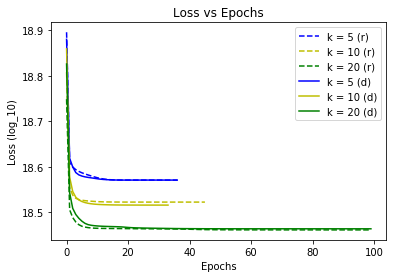

In [131]:
plt.plot(range(len(rand_loss_5)), np.log(rand_loss_5), 'b--', label = 'k = 5 (r)')
plt.plot(range(len(rand_loss_10)), np.log(rand_loss_10), 'y--', label = 'k = 10 (r)')
plt.plot(range(len(rand_loss_20)), np.log(rand_loss_20),  'g--', label = 'k = 20 (r)')
plt.plot(range(len(dist_loss_5)), np.log(dist_loss_5), 'b-', label = 'k = 5 (d)')
plt.plot(range(len(dist_loss_10)), np.log(dist_loss_10), 'y-', label = 'k = 10 (d)')
plt.plot(range(len(dist_loss_20)), np.log(dist_loss_20),  'g-', label = 'k = 20 (d)')
plt.xlabel('Epochs')
plt.ylabel('Loss (log_10)')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

## external metrics

Helper function to get confusion matrix and cluster mappings for `k` and `pi`'s

In [201]:
def get_mappings(k, pi):
    conf_mat = [[0 for x in range(k)] for y in range(k)]
    cluster_mapping = {}
    for cluster_id in range(k):
        true_labels = labels[np.where(cluster_id == pi)]
        conf_mat[cluster_id] = np.bincount(true_labels)
        cluster_mapping[cluster_id] = np.argmax(conf_mat[cluster_id])
    return cluster_mapping, np.array(conf_mat)

In [216]:
mapping, confusion_matrix = get_mappings(10, dist_pi_10)

### Purity

In [318]:
def purity(confusion_matrix):
    Pj = confusion_matrix.max(axis=1)
    Mj = confusion_matrix.sum(axis=1)
    return sum(Pj)/sum(Mj)

In [319]:
print('Aggregate purity: {0}'.format(purity(confusion_matrix)))

Aggregate purity: 0.5914857142857143


### Gini

In [331]:
def gini(confusion_matrix):
    Mj = confusion_matrix.sum(axis=1, keepdims=True)
    gj = 1 - ((confusion_matrix/Mj)**2).sum(axis=1, keepdims=True)
    return (sum(gj*Mj)/sum(Mj))[0]

In [333]:
print('Gini Index: {0}'.format(gini(confusion_matrix)))

Gini Index: 0.5484558045037563


## All together

In [369]:
def do_kmeans(ks):
    loss, pi = [], []
    seed = np.random.randint(n_rows)
    
    for k in ks:
        print('For k = {0}:'.format(k))
        _loss, _pi = kmeans(k=k, init_func=init, 
                            max_epochs=5, 
                            print_interval=10, 
                            seed=seed)
        loss.append(_loss)
        pi.append(_pi)
        print('\n\tFinal values: \n\t\tLoss: {0}'.format(_loss[-1]))
        mapping, conf_mat = get_mappings(k, _pi)
        _purity = purity(conf_mat)
        _gini = gini(conf_mat)
        print('\t\tPurity: {0}'.format(_purity))
        print('\t\tGini Index: {0}\n'.format(_gini))
        
#     for _loss in loss:
        plt.plot(range(len(_loss)), np.log(_loss), label = 'k = {0}'.format(k))
        plt.xlabel('Epochs')
        plt.ylabel('Loss (log_10)')
        plt.title('Loss vs Epochs')
        plt.legend()
        plt.show()

For k = 10:
	Epoch: 0 Loss: 150299930.467
	No convergence after 5 epochs, try higher value. Loss at 111319563.17328326

	Final values: 
		Loss: 111319563.17328326
		Purity: 0.537
		Gini Index: 0.5901213426562233



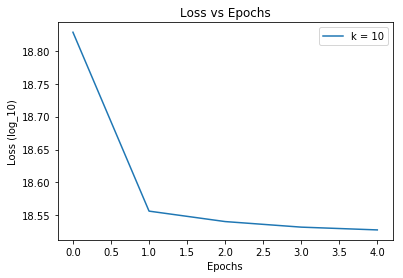

In [370]:
do_kmeans([10])